<img src = "images/Logo.png" width = 220, align = "left">

<h1 align=center><font size = 6><span style="color:blue">Weighted Least Squares</span></font></h1>
<h2 align=center><font size = 5>Lab Exercise 3.12</font></h2>
<h3 align=center><font size = 4><b>Advanced Machine Learning Made Easy<br></b><small>From Theory to Practice with NumPy and scikit-learn<br><i>Volume 1: Generalized Linear Models</i></font></h3>

## Introduction

Until now, we assumed that the error has constant variance (homoskedasticity). But in real applications, that might not be the case, and the error term has no constant variance, but it has a dependency on the input variable (heteroskedasticity). For example, in the semiconductor photomask line-spacing, it appears that the precision of the line-spacing measurements decreases as the line spacing increases. In situations like this, when it may not be reasonable to assume that every observation should be treated equally, weighted least squares can often be used to maximize the efficiency of parameter estimation. This is done by attempting to give each data point its proper amount of influence over the parameter estimates. <br>
The line-spacing measurement is used to calibrate the optical image system used in the IC photomasks. This is done by fitting a linear regression line on the measured data. It is very important to have this fit as precise as possible. As we will see, the R-squared value will not be good guidance in choosing the best fit.
**Note**: *The source of the "Integrated Circuit Photomasks" dataset can be found at https://www.itl.nist.gov/div898/handbook/datasets/LNSPCG.DAT.*

### Table of contents
1. [Reading and analyzing the data](#ReadingData)
2. [Checking for homoscedasticity](#Heteroscedasticity)
3. [Variance-stabilizing transformation](#Transformation)
4. [Weighted Least Squares (WLS)](#WLS)
5. [Iteratively Reweighted Least Squares (IRLS)](#IRLS)
6. [Comparing the result of different weight estimation methods](#Comparison)

## 1. Reading and analyzing the data <a name="ReadingData"></a>

As a first step, we import all the required libraries and set the plots to be made inline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols,wls
from numpy.linalg import inv
import os
%matplotlib inline

#### Loading the data

Read the "Line-spacing" dataset using the pandas library.

In [2]:
data=pd.read_csv(os.path.join('data',"LineSpacing.csv"),sep=' ')
print("Semiconductor Photomask Line-width Measurements Values in Micrometers")
data

Semiconductor Photomask Line-width Measurements Values in Micrometers


,w,z,d,z',r
0,6.19,6.31,0.12,6.3455,-0.0355
1,9.17,9.27,0.10,9.2869,-0.0169
2,1.99,2.21,0.22,2.2000,0.0100
3,7.77,8.00,0.23,7.9050,0.0950
4,4.00,4.27,0.27,4.1839,0.0861
5,10.77,10.93,0.16,10.8662,0.0638
6,4.78,4.95,0.17,4.9538,-0.0038
7,2.99,3.24,0.25,3.1870,0.0530
8,6.98,7.14,0.16,7.1253,0.0147
9,9.98,10.23,0.25,10.0864,0.1436


where
- w is the NBS Values in micrometers (NBS stands for the U.S. National Bureau of Standards)
- z is the Observed Values (line-width measurements for integrated-circuit photomasks)
- d is the Difference (deviation) from NBS
- z' is the Fitted Values (using linear regression to obtain the so-called calibration curve)
- r is the Deviations from Fit

For more information, see https://nvlpubs.nist.gov/nistpubs/Legacy/TN/nbstechnicalnote1164.pdf

#### Analyzing the data

The calibration curve is obtained in the form $z = \beta_0 + \beta_1 w$ which is a linear regression.

In [3]:
data[['w','z']].corr()

,w,z
w,1.000000,0.999769
z,0.999769,1.000000


We can see that we have almost a perfect correlation between the standard line-space $w$ and measured line-space $z$. <br>
Let's create a scatter plot matrix using seaborn libary.

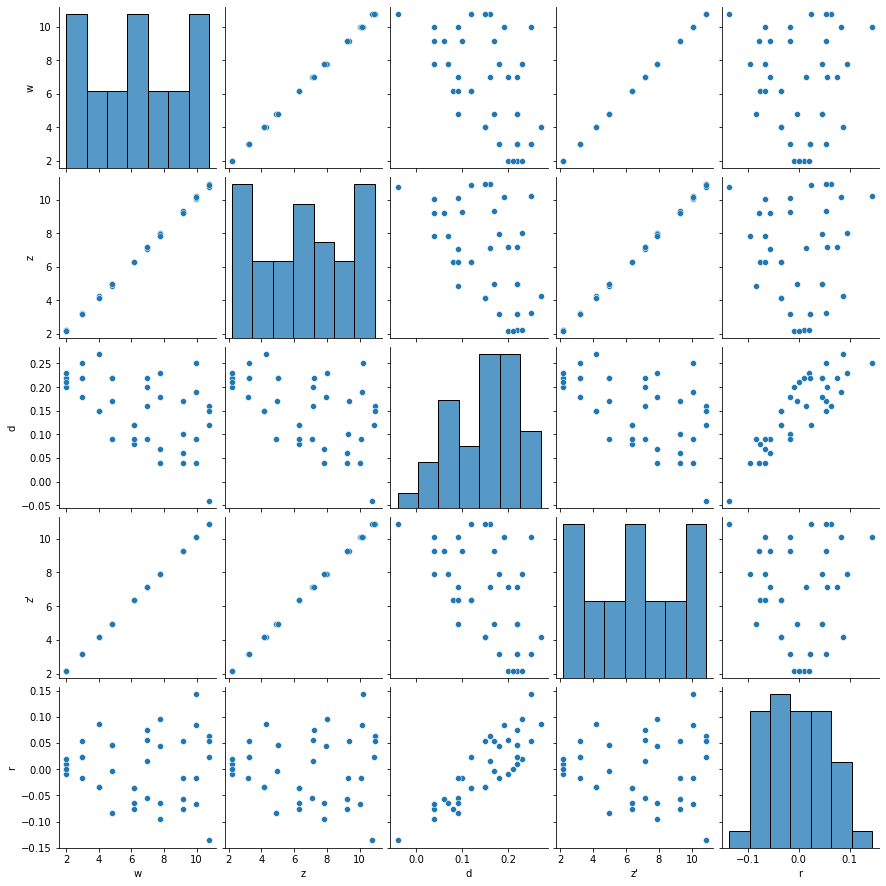

In [4]:
import seaborn as sns
sns.pairplot(data)

It appears that the precision of the line-spacing measurements (z) decreases as the line spacing increases (w).<br>
Let's make the scatter plot of the NBS standard and observed line-width with the fitted regression line. 

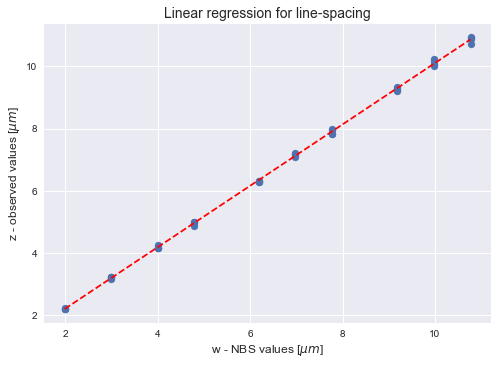

In [5]:
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn')
x_=data['w'].to_numpy().reshape(-1, 1)
y_=data['z'].to_numpy().reshape(-1, 1)
N=len(x_)
linregr=LinearRegression()
linregr.fit(x_,y_)
plt.scatter(x_,y_)
w_minmax=np.array([x_.min(),x_.max()]).reshape(-1, 1)
plt.plot(w_minmax,linregr.predict(w_minmax).reshape(-1, 1),'r--')
plt.xlabel("w - NBS values [$\mu m$]",fontsize=12)
plt.ylabel("z - observed values [$\mu m$]",fontsize=12)
plt.title("Linear regression for line-spacing",fontsize=14)
plt.show()

That looks very, very good. 

#### Checking the obtained result

The R-squared value is even more impressive.

In [6]:
r2=linregr.score(x_,y_)
print("R-squared =",r2)
print("Coefficients (Beta0, Beta1) =",(linregr.intercept_[0],linregr.coef_[0][0]))

R-squared = 0.999538492214726
Coefficients (Beta0, Beta1) = (0.23576229029298368, 0.9870377142845892)


The R-squared value is remarkably good, but as we will see later, still not good enough.

## 2. Checking for homoscedasticity <a name="Heteroscedasticity"></a>

*Shall we stop our analysis just because we have a very impressive R-squared value?*

Lat's analyze the obtained residuals.
We can calculate the residuals, which should be the same as the values in the column 'r' of the dataset (remember, the columns contain only rounded values!).

In [7]:
r_=y_-linregr.predict(x_)
print("Diff. in the sum of absolute differences of residuals:", np.abs(r_-data['r'].to_numpy().reshape(-1,1)).sum())
print("RMSE=",float(np.sqrt(r_.T@r_/(N-1))))

Diff. in the sum of absolute differences of residuals: 0.0007347200592252331
RMSE= 0.06123151346366192


So far, so good! But let's make the residual plot.

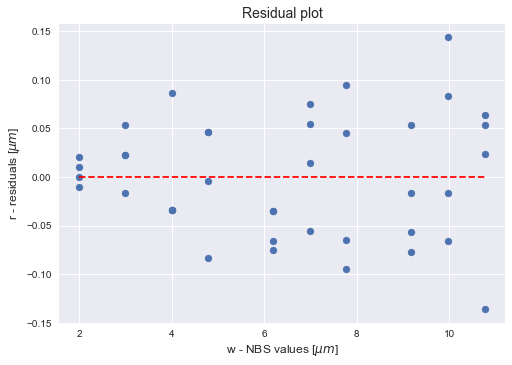

In [8]:
plt.scatter(x_,r_)
plt.plot(w_minmax,[[0],[0]],'r--')
plt.xlabel("w - NBS values [$\mu m$]",fontsize=12)
plt.ylabel("r - residuals [$\mu m$]",fontsize=12)
plt.title("Residual plot",fontsize=14)
plt.show()

From the residual plot, we can observe that the residuals have no constant variance! <br>
The spread of measured line-width is much smaller at w=2 than at w>10. Thus, as the NBS values increase, so does the variance of the residuals. That means we should expect that the OLS will not provide the best solution.

We can also use the Goldfeld-Quandt test from the statsmodels library to check for homoskedasticity:

In [9]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
results = smf.ols('z ~ w', data=data).fit()
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print(lzip(name, test))

[('F statistic', 0.42560375563759073), ('p-value', 0.9609155908361985)]


According to the p-value, we can reject the null hypothesis that the lower and upper half of the residuals have the same variance. Thus, we face the problem of heteroskedasticity.

## 3. Variance-stabilizing transformation <a name="Transformation"></a>

A first attempt to solve the heteroskedasticity problem is to use a variance-stabilizing transformation, i.e., to transform the dependent variable.

#### Transformation of the form $\sqrt {\mathbf y}$

Fit the linear model using the square root of the independent variable (assuming that $\sigma_\epsilon^2\propto \mathbb E \left [ y \right ]$), and make the scatter plot with the estimated regression line. Also, report the R-squared value and the estimated coefficients.

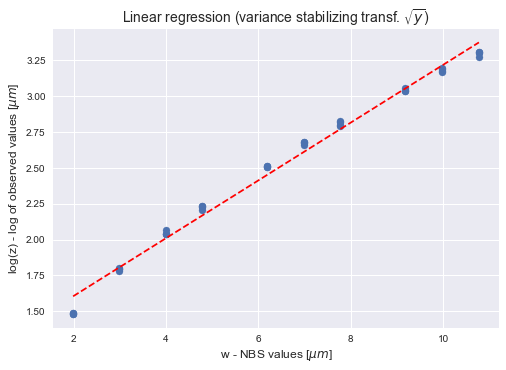

R-squared = 0.9890732002703833
Coefficients (Beta0, Beta1) = (1.2036670133895686, 0.20154381996717768)


In [10]:
linregr.fit(x_,np.sqrt(y_))
plt.scatter(x_,np.sqrt(y_))
w_minmax=np.array([x_.min(),x_.max()]).reshape(-1, 1)
plt.plot(w_minmax,linregr.predict(w_minmax).reshape(-1, 1),'r--')
plt.xlabel("w - NBS values [$\mu m$]",fontsize=12)
plt.ylabel("log(z) - log of observed values [$\mu m$]",fontsize=12)
plt.title("Linear regression (variance stabilizing transf. $\sqrt{y}$)",fontsize=14)
plt.show()
from sklearn.metrics import r2_score
print("R-squared =",r2_score(np.sqrt(y_),linregr.predict(x_)))
print("Coefficients (Beta0, Beta1) =",(linregr.intercept_[0],linregr.coef_[0][0]))

The R-squared value is dropped. The estimate of coefficients is changed, but that should not be a surprise as we fit the linear model using the logarithm of the output variable. Let's create the residual plot.

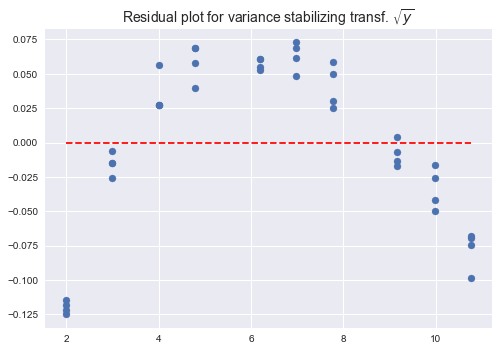

RMSE= 0.06115799694202491


In [11]:
r_=(np.sqrt(y_)-linregr.predict(x_))
plt.scatter(x_,r_)
plt.plot(w_minmax,[[0],[0]],'r--')
plt.title("Residual plot for variance stabilizing transf. $\sqrt{y}$",fontsize=14)
plt.show()
print("RMSE=",float(np.sqrt(r_.T@r_/(N-1))))

Although the RMSE is almost the same and the variance of the residuals seems to be constant, the residual plot shows that the relationship is not linear between $\sqrt y$ and $x$.

#### Transformation of the form $\log(\mathbf y)$

Take the logarithm of the dependent variable (assuming that $\sigma_\epsilon^2\propto \left(\mathbb E \left [ y \right ]\right)^2$) and fit the regression line. Then print out the R-squared value and estimate of coefficients.

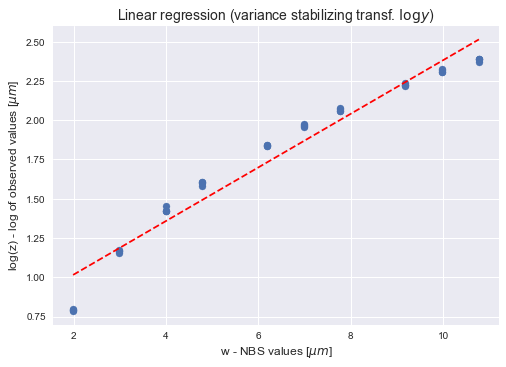

R-squared = 0.9537187317865731
Coefficients (Beta0, Beta1) = (0.6752960218530575, 0.17073868080010376)


In [12]:
linregr.fit(x_,np.log(y_))
plt.scatter(x_,np.log(y_))
w_minmax=np.array([x_.min(),x_.max()]).reshape(-1, 1)
plt.plot(w_minmax,linregr.predict(w_minmax).reshape(-1, 1),'r--')
plt.xlabel("w - NBS values [$\mu m$]",fontsize=12)
plt.ylabel("log(z) - log of observed values [$\mu m$]",fontsize=12)
plt.title("Linear regression (variance stabilizing transf. $\log{y}$)",fontsize=14)
plt.show()
from sklearn.metrics import r2_score
print("R-squared =",r2_score(np.log(y_),linregr.predict(x_)))
print("Coefficients (Beta0, Beta1) =",(linregr.intercept_[0],linregr.coef_[0][0]))

The R-squared value is further dropped. Let's create the residual plot.

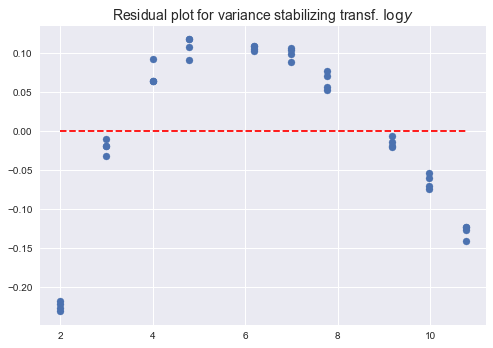

RMSE= 0.10858651214387895


In [13]:
r_=(np.log(y_)-linregr.predict(x_))
plt.scatter(x_,r_)
plt.plot(w_minmax,[[0],[0]],'r--')
plt.title("Residual plot for variance stabilizing transf. $\log{y}$",fontsize=14)
plt.show()
print("RMSE=",float(np.sqrt(r_.T@r_/(N-1))))

The RMSE is increased and, while the variance of the residuals seems to be constant, the residual plot does not show a linear relationship between the $\log y$ and $x$.

#### Transformation of the form $\frac{1}{\sqrt y}$

Now, take the inverse of the square root of the output (assuming that $\sigma_\epsilon^2\propto \left(\mathbb E \left [ y \right ]\right)^3$) before fitting the linear model.

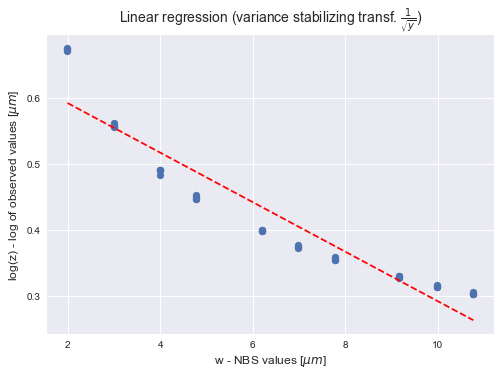

R-squared = 0.8938117829771034
Coefficients (Beta0, Beta1) = (0.6675903556197792, -0.037619019779433445)


In [14]:
linregr.fit(x_,1/np.sqrt(y_))
plt.scatter(x_,1/np.sqrt(y_))
w_minmax=np.array([x_.min(),x_.max()]).reshape(-1, 1)
plt.plot(w_minmax,linregr.predict(w_minmax).reshape(-1, 1),'r--')
plt.xlabel("w - NBS values [$\mu m$]",fontsize=12)
plt.ylabel("log(z) - log of observed values [$\mu m$]",fontsize=12)
plt.title(r"Linear regression (variance stabilizing transf. $\frac{1}{\sqrt{y}}$)",fontsize=14)
plt.show()
from sklearn.metrics import r2_score
print("R-squared =",r2_score(1/np.sqrt(y_),linregr.predict(x_)))
print("Coefficients (Beta0, Beta1) =",(linregr.intercept_[0],linregr.coef_[0][0]))

The R-squared value is even further dropped. Let's create the residual plot.

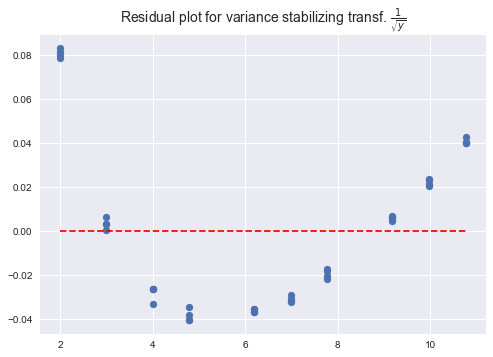

RMSE= 0.037434677368901444


In [15]:
r_=(1/np.sqrt(y_))-linregr.predict(x_)
plt.scatter(x_,r_)
plt.plot(w_minmax,[[0],[0]],'r--')
plt.title(r"Residual plot for variance stabilizing transf. $\frac{1}{\sqrt{y}}$",fontsize=14)
plt.show()
print("RMSE=",float(np.sqrt(r_.T@r_/(N-1))))

Again, the residual plot reveals that there is no linear relation between $\frac{1}{\sqrt y}$ and $x$.

#### Transformation of the form $\frac{1}{y}$

Finally, take the inverse of the output (assuming that $\sigma_\epsilon^2\propto \left(\mathbb E \left [ y \right ]\right)^4$) before fitting the linear model.

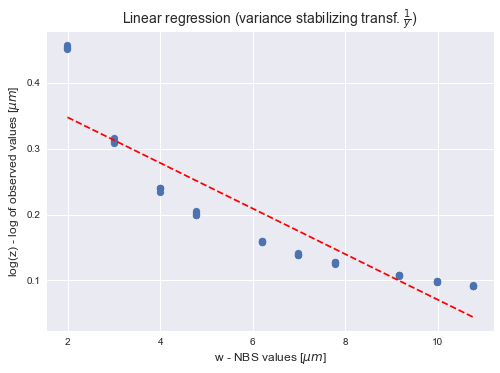

R-squared = 0.8159115746267206
Coefficients (Beta0, Beta1) = (0.41635326249975824, -0.034554196973580656)


In [16]:
linregr.fit(x_,1/y_)
plt.scatter(x_,1/y_)
w_minmax=np.array([x_.min(),x_.max()]).reshape(-1, 1)
plt.plot(w_minmax,linregr.predict(w_minmax).reshape(-1, 1),'r--')
plt.xlabel("w - NBS values [$\mu m$]",fontsize=12)
plt.ylabel("log(z) - log of observed values [$\mu m$]",fontsize=12)
plt.title(r"Linear regression (variance stabilizing transf. $\frac{1}{y}$)",fontsize=14)
plt.show()
from sklearn.metrics import r2_score
print("R-squared =",r2_score(1/y_,linregr.predict(x_)))
print("Coefficients (Beta0, Beta1) =",(linregr.intercept_[0],linregr.coef_[0][0]))

The R-squared value is even further dropped. Let's create the residual plot.

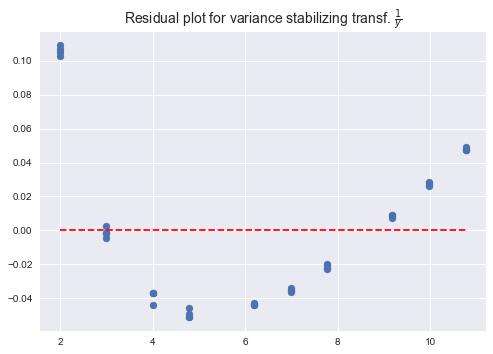

RMSE= 0.047385338978116226


In [17]:
r_=(1/y_)-linregr.predict(x_)
plt.scatter(x_,r_)
plt.plot(w_minmax,[[0],[0]],'r--')
plt.title(r"Residual plot for variance stabilizing transf. $\frac{1}{y}$",fontsize=14)
plt.show()
print("RMSE=",float(np.sqrt(r_.T@r_/(N-1))))

We can conclude that in this particular case, the transformation of the form $\sqrt {\mathbf y}$ provided the best result, but even that is inferior to the OLS result. So the variance-stabilizing transformation is not a good option.

Let's use the Weighted Least Squares (WLS) method.

## 4. Weighted Least Squares (WLS) <a name="WLS"></a>

In the case of WLS, we have to know the variance of the errors for each value of $x$. However, this is unknown in most cases, so we need to find a way to estimate them.

#### Estimating the variance as the inverse of the  i-th predictor

From the residual plot of the linear regression, it is clear that the residual has an increasing spread (variance) as the predictor value is increasing. Thus, let's estimate the weight as the inverse of the predictor.
For this, we first create the OLS again, then calculate the residuals.

In [18]:
x_=data['w'].to_numpy().reshape(-1, 1)
y_=data['z'].to_numpy().reshape(-1, 1)
linregr.fit(x_,y_)
r_=y_-linregr.predict(x_)
r_

array([[-3.55257417e-02],
       [-1.68981303e-02],
       [ 1.00326583e-02],
       [ 9.49546697e-02],
       [ 8.60868526e-02],
       [ 6.38415269e-02],
       [-3.80256457e-03],
       [ 5.29949440e-02],
       [ 1.47144640e-02],
       [ 1.43601321e-01],
       [-7.55257417e-02],
       [-7.68981303e-02],
       [-9.96734172e-03],
       [-9.50453303e-02],
       [-3.39131474e-02],
       [-1.36158473e-01],
       [-8.38025646e-02],
       [-1.70050560e-02],
       [-5.52855360e-02],
       [-6.63986789e-02],
       [-3.55257417e-02],
       [ 5.31018697e-02],
       [ 2.00326583e-02],
       [ 4.49546697e-02],
       [-3.39131474e-02],
       [ 5.38415269e-02],
       [ 4.61974354e-02],
       [ 2.29949440e-02],
       [ 5.47144640e-02],
       [-1.63986789e-02],
       [-6.55257417e-02],
       [-5.68981303e-02],
       [ 3.26582807e-05],
       [-6.50453303e-02],
       [-3.39131474e-02],
       [ 2.38415269e-02],
       [ 4.61974354e-02],
       [ 2.29949440e-02],
       [ 7.4

Then estimate the weight as the inverse of the predictor x. We can use the scikit-learn linear regression model with the weights attribute included.

In [19]:
w1_=1/(x_)
linregr.fit(x_,y_,w1_.ravel())
yhat_=linregr.predict(x_)
print("R-squared =",linregr.score(x_,y_,w1_.ravel()))
print("Coefficients(Beta0,Beta1) =",(linregr.intercept_[0],linregr.coef_[0][0]))

R-squared = 0.9996577420671773
Coefficients(Beta0,Beta1) = (0.24341054330512435, 0.9858541406213054)


Similar results are obtained if we use the formulas derived in the book for the estimate of regression coefficients:

In [20]:
Xdot=np.insert(x_,0,np.ones(N),axis=1)
W=np.diag(np.ravel(w1_))
inv(Xdot.T@W@Xdot)@Xdot.T@W@y_

array([[0.24341054],
       [0.98585414]])

Using the formula for the weighted R-squared score we have:

In [21]:
WSST=(y_-np.average(y_,weights=w1_)).T@W@(y_-np.average(y_,weights=w1_))
WSSE=(y_-yhat_).T@W@(y_-yhat_)
(WSST-WSSE)/WSST

array([[0.99965774]])

In contrast to the variance-stabilizing transformation, we can see now a very small improvement in the R-squared value. Of course, this improvement is small because the R-squared value is almost 1. 

Let's make the residual plot.

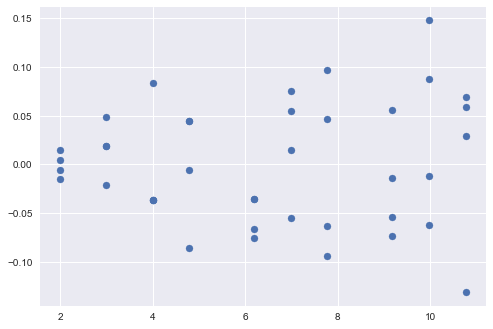

In [22]:
r_=(y_-linregr.predict(x_))
plt.scatter(x_,r_)
plt.show()

But wait, the residual plot looks the same!<br>
Yes, because the coefficients are changed very little, so after all, almost the same residuals shall be seen. If we want to see the effect of the weights, we should multiply each residual with the corresponding square root of the weight when making the residual plot.

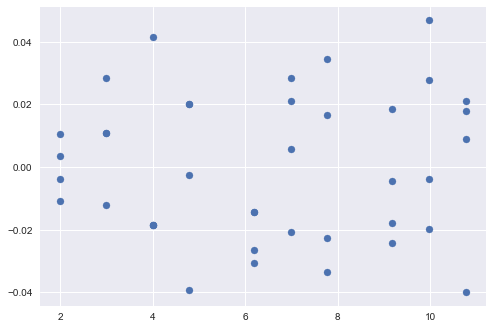

In [23]:
r_=(y_-linregr.predict(x_))*np.sqrt(w1_)
plt.scatter(x_,r_)
plt.show()

The residual plot is improved significantly.

#### Estimating the variance as the sample variance of the response variable

Because for a given input 'w' there are at least three output 'z' values, one might try to estimate the true error from the variance of the response variable samples.

In [24]:
data.groupby('w').var(ddof=1)

,z,d,z',r
w,,,,
1.99,0.000167,0.000167,0.0,0.000167
2.99,0.000825,0.000825,0.0,0.000825
4.00,0.003600,0.003600,0.0,0.003600
4.78,0.003767,0.003767,0.0,0.003767
6.19,0.000425,0.000425,0.0,0.000425
6.98,0.003292,0.003292,0.0,0.003292
7.77,0.008067,0.008067,0.0,0.008067
9.17,0.003292,0.003292,0.0,0.003292
9.98,0.009025,0.009025,0.0,0.009025


The estimate of the variances of the response variables is stored in column 'z' in the above table (the variance is the same as the variance of the residuals). Then the reciprocal of the columns 'z' could be used as the estimates for the weights.

In [25]:
w2_=np.array([1/data.groupby('w').var(ddof=1).loc[w,'z'] for w in data['w']])[:,np.newaxis]
w2_

array([[2352.94117647],
       [ 303.79746835],
       [6000.        ],
       [ 123.96694215],
       [ 277.77777778],
       [ 115.0527325 ],
       [ 265.48672566],
       [1212.12121212],
       [ 303.79746835],
       [ 110.8033241 ],
       [2352.94117647],
       [ 303.79746835],
       [6000.        ],
       [ 123.96694215],
       [ 277.77777778],
       [ 115.0527325 ],
       [ 265.48672566],
       [1212.12121212],
       [ 303.79746835],
       [ 110.8033241 ],
       [2352.94117647],
       [ 303.79746835],
       [6000.        ],
       [ 123.96694215],
       [ 277.77777778],
       [ 115.0527325 ],
       [ 265.48672566],
       [1212.12121212],
       [ 303.79746835],
       [ 110.8033241 ],
       [2352.94117647],
       [ 303.79746835],
       [6000.        ],
       [ 123.96694215],
       [ 277.77777778],
       [ 115.0527325 ],
       [ 265.48672566],
       [1212.12121212],
       [ 303.79746835],
       [ 110.8033241 ]])

Fit the linear regression using the estimated weights.

In [26]:
linregr.fit(x_,y_,w2_.ravel())
print("R-squared =",linregr.score(x_,y_,w2_.ravel()))
print("Coefficients(Beta0,Beta1) =",(linregr.intercept_[0],linregr.coef_[0][0]))

R-squared = 0.9997762917643853
Coefficients(Beta0,Beta1) = (0.2536713367317147, 0.9805105729443216)


Finally, let's create the weighted residual plot.

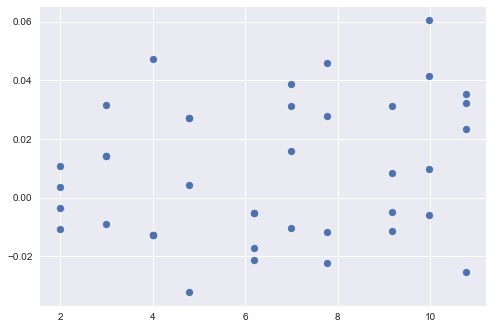

(-0.03225138112319792, 0.06040717662556708)

In [27]:
r_=(y_-linregr.predict(x_))*np.sqrt(w1_)
plt.scatter(x_,r_)
plt.show()
r_.min(),r_.max()

As can be seen, the residual plot do not show any sing of heteroskedacticity.

## 5. Iteratively Reweighted Least Squares (IRLS) <a name="IRLS"></a>

IRLS is an optimization method that starts with a weight matrix equal to the identity matrix (corresponding to OLS) then iteratively estimating the coefficients of the linear model and the weights of WLS. 

**Note:** *The IRLS algorithm will be discussed in Chapter 5 of the book. Here is used only to make a complete comparison of different solutions for his real practical example.* 

Let's define the IRLS function as described in the E-book.

In [28]:
def IRLS(X,y_):
    N,D=X.shape
    delta=0.001*np.ones((N,1))
    W=np.eye(N)
    maxiter=50
    w_=inv(X.T@W@X)@X.T@W@y_
    for _ in range(maxiter):
        wold_=w_
        W=np.diag(np.squeeze(1.0/np.maximum(delta,np.abs(y_-X@w_))))
        w_=inv(X.T@W@X)@X.T@W@y_
        tol=np.sum(np.abs(w_-wold_))
        if tol < 0.0001:
            return w_,W
    return w_,W

Then fit the linear model using IRLS function (w_, as before, represents the 'weight' being the estimate of the coefficients, while W represents the weight matrix of the WLS method).

In [29]:
X=np.insert(x_,0,np.ones(N),axis=1)
w_,W=IRLS(X,y_)
np.diag(W)

array([  35.10860484,  232.83524605,  108.24461776,    9.52874834,
         11.23051613,   12.58965312, 1000.        ,   18.49571489,
         43.04543719,    6.34051102,   14.60215427,   15.55333741,
         92.92242092,   11.75717821,   32.30297874,    8.29395818,
         12.59590711,   62.76115457,   21.38180604,   19.12630804,
         35.10860484,   15.21951465,   51.97955123,   18.19982683,
         32.30297874,   14.40293234,   19.75927984,   41.5514007 ,
         15.81496092,  437.82726575,   17.09897264,   22.57597144,
       1000.        ,   18.16384514,   32.30297874,   25.36120313,
         19.75927984,   41.5514007 ,   12.01471572,   10.23373919])

Make a linear fit using the linear regression with weights from the scikit-learn library.

In [30]:
linregr.fit(x_,y_,np.diag(W))
print("R-squared =",linregr.score(x_,y_,np.diag(W)))
print("Coefficients(Beta0,Beta1) =",(linregr.intercept_[0],linregr.coef_[0][0]))

R-squared = 0.9999347246079366
Coefficients(Beta0,Beta1) = (0.24033661894831138, 0.9851499572769469)


We can observe that the R-squared value is slightly improved further.

## 6. Comparing the result of different weight estimation methods <a name="Comparison"></a>

Finally, make a comparison of the OLS with WLS using statsmodels library (in case of WLS we check the three different techniques used to estimate the weights). The coefficients of the linear model are not affected whether we use unnormalized or normalized weights.

**Note:** *We use normalized weights in order to have meaningful RMSE values.*

Let's start with the OLS.

In [31]:
model = ols(formula = 'z ~ w', data=data).fit()
print(model.summary())
print("\nR-squared =",model.rsquared)
print("RMSE =",np.sqrt(model.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.230e+04
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           5.35e-65
Time:                        12:26:05   Log-Likelihood:                 55.473
No. Observations:                  40   AIC:                            -106.9
Df Residuals:                      38   BIC:                            -103.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2358      0.024      9.702      0.0

Next, we use the WLS with weight w1_ defined earlier.

In [32]:
wls1_model = wls(formula = 'z ~ w', weights=w1_.ravel()/w1_.sum(),data=data).fit()
print(wls1_model.summary())
print("\nR-squared =",wls1_model.rsquared)
print("RMSE =",np.sqrt(wls1_model.mse_resid))

                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.110e+05
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           1.83e-67
Time:                        12:26:05   Log-Likelihood:                 59.879
No. Observations:                  40   AIC:                            -115.8
Df Residuals:                      38   BIC:                            -112.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2434      0.017     14.586      0.0

In the next step, we use WLS with the weights w2_ defined earlier.

In [33]:
wls2_model = wls(formula = 'z ~ w', weights=w2_.ravel()/w2_.sum(),data=data).fit()
print(wls2_model.summary())
print("\nR-squared =",wls2_model.rsquared)
print("RMSE =",np.sqrt(wls2_model.mse_resid))

                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.698e+05
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           5.66e-71
Time:                        12:26:05   Log-Likelihood:                 59.907
No. Observations:                  40   AIC:                            -115.8
Df Residuals:                      38   BIC:                            -112.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2537      0.010     24.622      0.0

Finally, we use the WLS with the weight matrix obtained form the IRLS method.

In [34]:
wls3_model = wls(formula = 'z ~ w', weights=np.diag(W)/W.sum(),data=data).fit()
print(wls3_model.summary())
print("\nR-squared =",wls3_model.rsquared)
print("RMSE =",np.sqrt(wls3_model.mse_resid))

                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.821e+05
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           3.89e-81
Time:                        12:26:05   Log-Likelihood:                 70.899
No. Observations:                  40   AIC:                            -137.8
Df Residuals:                      38   BIC:                            -134.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2403      0.007     32.149      0.0

#### Conclusion

Although in the R-squared value only very infinitesimal improvement can be seen (being already close to 1 for OLS), but looking at different other statistics improvement can be observed. For example, the RMSE value is decreased from 0.062 to 0.0038, and the F-statistic is increased from 8.230e+04 to 5.821e+05. Similarly, the t-statistic for the coefficient is also increased from 286.881 to 762.962, so we can be more confident in our slope estimate being nonzero. Moreover, the standard error for the slope is decreased from 0.003 to 0.001 resulting in a narrower confidence interval: [0.980, 0.994] --> [0.983, 0.988]

In this case, the best result could be obtained with IRLS.

<img src = "images/AML1-Cover.png" width = 110, align = "left" style="margin:0px 20px">

<span style="color:blue">**Note:**</span> This Jupyter Notebook is accompanying the book: <br> $\qquad$ <b>Advanced Machine Learning Made Easy</b> <br> $\qquad$ From Theory to Practice with NumPy and scikit-learn <br> $\qquad$ <i> Volume 1: Generalized Linear Models</i><br>
by Ferenc Farkas, Ph.D. 

If you find this Notebook useful, please support me by buying the book at [Leanpub](http://leanpub.com/AML1). <br>
Copyright notice: This Jupyter Notebook is made available under the [MIT License](https://opensource.org/licenses/MIT).